In this notebook, we walk through the design of target encoding. We start with a motivating example, `criteo dataset`, to show why target encoding is preferred over one hot encoding and label encoding. The concepts and optimizations of target encoding are introduced step by step. The key takeaway is that target encoding differs from traditional sklearn style encoders in the following aspects:

- The ground truth column `target` is used as input for encoding.
- The training data and test data are transformed differently.
- Multi-column joint transformation is supported by target encoding.

### Table of contents
[1. Motivation](#motivation)<br>
> [Criteo data](#criteo)<br>
[Why not one-hot encoding?](#onehot)<br>
[Label encoding](#lbl)<br>
[Train XGB with label encoding ](#lblxgb)<br>

[2. Target Encoding](#tar)<br>
> [A naive implementation](#naive)<br>
[A K-fold cross validate implementation](#kfold)<br>
[An optimized implementation](#opt)<br>
[Multi-column joint encoding](#multi)<br>

[3. Conclusions](#conclusions)<br>

In [1]:
import os
GPU_id = '0,1,2,3'
os.environ['CUDA_VISIBLE_DEVICES'] = GPU_id
num_gpus = len(GPU_id.split(','))

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import cudf as gd
import cupy as cp
from cuml.preprocessing.LabelEncoder import LabelEncoder
import dask as dask, dask_cudf
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster
import xgboost as xgb
import matplotlib.pyplot as plt
import time

<a id="motivation"></a>
## 1. Motivation

<a id="criteo"></a>
### Criteo data
The [criteo 1-TB benchmark](https://github.com/rambler-digital-solutions/criteo-1tb-benchmark) is a well-known dataset for click thourgh rate modeling. We only use three categorical features to make it a simple dataset for the problem.

In [3]:
%%time

path = '/raid/data/criteo'
train_name = f'{path}/day_0_part_0000'
valid_name = f'{path}/day_0_part_0001'
num_cols = ['num_%d'%i for i in range(13)]
cat_cols = ['cat_%d'%i for i in range(26)]
cols = ['label']+num_cols+cat_cols
dtypes = {i:'str' if i.startswith('cat_') else 'float32' for i in cols}
train = gd.read_csv(train_name, sep = '\t', header=None, names=cols, dtypes=dtypes)
valid = gd.read_csv(valid_name, sep = '\t', header=None, names=cols, dtypes=dtypes)

used_cols = ['label']+cat_cols[:3]

train = train[used_cols]
valid = valid[used_cols]
train.head()

CPU times: user 1.34 s, sys: 717 ms, total: 2.05 s
Wall time: 2.06 s


,label,cat_0,cat_1,cat_2
0,1,62770d79,e21f5d58,afea442f
1,0,e5f3fd8d,a0aaffa6,6faa15d5
2,0,62770d79,ad984203,62bec60d
3,0,None,710103fd,c73d2eb5
4,0,02e197c5,c2ced437,a2427619


The categorical columns are strings originally so we need some kind of encoding to turn them into numerical columns.

<a id="onehot"></a>
### Why not one-hot encoding?

In [4]:
for col in cat_cols[:3]:
    print(col,'cardinality',len(train[col].unique()), len(valid[col].unique()))

cat_0 cardinality 344950 341085
cat_1 cardinality 14969 14735
cat_2 cardinality 12657 12509


With such high cardinality, it is inefficient to do one-hot encoding because it leads to either huge memory consumption or very sparse data, which is less optimized when running on GPU.

Therefore, we use label encoding to transform such string columns to numerical columns.

<a id="lbl"></a>
### Label encoding

In [5]:
%%time
for col in cat_cols[:3]:
    train[col] = train[col].fillna('None')
    valid[col] = valid[col].fillna('None')
    lbl = LabelEncoder()
    lbl.fit(gd.concat([train[col],valid[col]]))
    train[col] = lbl.transform(train[col])
    valid[col] = lbl.transform(valid[col])

CPU times: user 521 ms, sys: 321 ms, total: 842 ms
Wall time: 843 ms


In [6]:
train.head()

,label,cat_0,cat_1,cat_2
0,1,236119,15269,9218
1,0,552635,10839,5875
2,0,236119,11675,5199
3,0,384082,7647,10421
4,0,6992,13137,8523


Label encoding transforms string columns to integer columns. However, the mapping from a string to an integer is arbitary, which makes the encoded features less informative. For example, the first three rows of `cat_2` are `9218`, `5875` and `5199`. Although `5875` is closer to `5199` than `9218`, there is absolutely no guarantee that the string of `5875` is more similar to string of `5199` than string of `9218`. In other words, a tree classifier has make many splits to learn the pattern buried within such encoded features.   

<a id="lblxgb"></a>
### Train XGB with label encoding features

In [7]:
xgb_parms = { 
    'max_depth':6, 
    'learning_rate':0.1, 
    'subsample':0.8,
    'colsample_bytree':0.3, 
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'tree_method':'gpu_hist',
}

In [8]:
NROUND = 100
VERBOSE_EVAL = 10
ESR = 10

start = time.time(); print('Creating DMatrix...')
dtrain = xgb.DMatrix(data=train.drop('label',axis=1),label=train['label'])
dvalid = xgb.DMatrix(data=valid.drop('label',axis=1),label=valid['label'])
print('Took %.1f seconds'%(time.time()-start))

start = time.time(); print('Training...')
model = xgb.train(xgb_parms, 
                       dtrain=dtrain,
                       evals=[(dtrain,'train'),(dvalid,'valid')],
                       num_boost_round=NROUND,
                       early_stopping_rounds=ESR,
                       verbose_eval=VERBOSE_EVAL) 

Creating DMatrix...
Took 0.1 seconds
Training...
[0]	train-auc:0.55893	valid-auc:0.55159
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[10]	train-auc:0.61074	valid-auc:0.60278
[20]	train-auc:0.61219	valid-auc:0.60475
Stopping. Best iteration:
[17]	train-auc:0.61445	valid-auc:0.60751



As shown above, using label encoding features results in a valid auc score of 0.60. Let's see if target encoding can improve this score.

<a id="tar"></a>
## 2. Target encoding

The idea of target encoding is very simple: we encode the categorical column by the mean value of the `target` of the group associated with each unique value of the categorical column, where `target` is the ground truth column to be predicted. In other words, it is essentially just a simple groupby-aggregation-merge or `groupby-transform`, in pandas terms:<br> `df['fea_encode'] = df.groupby('fea')['target'].transform(lambda x: x.mean())`

<a id="naive"></a>
### A naive implementation
Let's implement targe encoding of the idea above and study where we can improve.

In [9]:
%%time
for col in cat_cols[:3]:
    tmp = train.groupby(col, as_index=False).agg({'label':'mean'})
    tmp.columns = [col, f'{col}_TE']
    train = train.merge(tmp, on=col, how='left')
    valid = valid.merge(tmp, on=col, how='left')
    del tmp
train.head()

CPU times: user 76.7 ms, sys: 24.6 ms, total: 101 ms
Wall time: 100 ms


,label,cat_0,cat_1,cat_2,cat_0_TE,cat_1_TE,cat_2_TE
0,0,331710,4302,9458,0.010220,0.007404,0.000000
1,0,511504,13628,4878,0.047717,0.049066,0.030230
2,0,155375,4518,4922,0.061069,0.043478,0.012175
3,0,91607,15196,2491,0.037622,0.086066,0.056960
4,0,103851,3213,2782,0.000000,0.024103,0.047386


We will only use the target encoding features to train XGB.

In [10]:
te_cols = [col for col in train.columns if col.endswith('TE')]
print(te_cols)

NROUND = 100
VERBOSE_EVAL = 10
ESR = 10

start = time.time(); print('Creating DMatrix...')
dtrain = xgb.DMatrix(data=train[te_cols],label=train['label'])
dvalid = xgb.DMatrix(data=valid[te_cols],label=valid['label'])
print('Took %.1f seconds'%(time.time()-start))

start = time.time(); print('Training...')
model = xgb.train(xgb_parms, 
                       dtrain=dtrain,
                       evals=[(dtrain,'train'),(dvalid,'valid')],
                       num_boost_round=NROUND,
                       early_stopping_rounds=ESR,
                       verbose_eval=VERBOSE_EVAL) 

['cat_0_TE', 'cat_1_TE', 'cat_2_TE']
Creating DMatrix...
Took 0.0 seconds
Training...
[0]	train-auc:0.79707	valid-auc:0.55546
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[10]	train-auc:0.84162	valid-auc:0.63906
[20]	train-auc:0.84085	valid-auc:0.65804
[30]	train-auc:0.84032	valid-auc:0.68096
[40]	train-auc:0.84373	valid-auc:0.67309
Stopping. Best iteration:
[33]	train-auc:0.83985	valid-auc:0.68734



Immediately the valid auc is improved to `0.65` from `0.6`, even with the naive target encoding. Great! However, the bigger discrepancy between `train auc` and `valid auc` is alarming. It means the naive target encoding is creating an overfitting problem. 

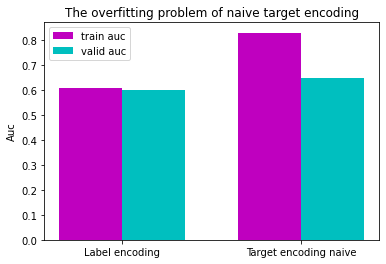

In [11]:
labels = ['Label encoding', 'Target encoding naive']
train_auc = [0.61, 0.83]
valid_auc = [0.60, 0.65]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_auc, width, label='train auc', color='m')
rects2 = ax.bar(x + width/2, valid_auc, width, label='valid auc', color='c')

ax.set_ylabel('Auc')
ax.set_title('The overfitting problem of naive target encoding')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

The cause is actually obvious. We use the ground truth column directly in creating the features for the training data, which doesn't generalize to validation data  

<a id="kfold"></a>
### A K-fold cross validate implementation
To alleviate such overfitting, we can encode the traning data in k-folds, so that a sample's ground truth is not touched when creating its target encoding feature. The procedure is shown in the animation below.<br>
![ChessUrl](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F100236%2F64cc45bbe25144503bc93cf4b9e102f1%2Fmte.gif?generation=1594620515929361&alt=media "chess")

In [12]:
# drop the naive TE columns
train = train.drop(te_cols, axis=1)
valid = valid.drop(te_cols, axis=1)

In [13]:
%%time
FOLDS = 10
train['fold'] = cp.random.randint(0,FOLDS,len(train))
train['row_id'] = cp.arange(len(train))
mean = train['label'].mean()
for col in cat_cols[:3]:
    res = []
    out_col = f'{col}_TE'
    for i in range(FOLDS):
        tmp = train[train['fold']!=i].groupby(col, as_index=False).agg({'label':'mean'})
        tmp.columns = [col, out_col]
        tr = train[train['fold']==i][['row_id',col]]
        tr = tr.merge(tmp,on=col,how='left')
        res.append(tr)
        del tmp
    res = gd.concat(res)
    res = res.sort_values('row_id')
    train[out_col] = res[out_col].fillna(mean).values
    del res
    tmp = train.groupby(col, as_index=False).agg({'label':'mean'})
    tmp.columns = [col, out_col]
    valid = valid.merge(tmp, on=col, how='left')
    del tmp
train.head()

CPU times: user 715 ms, sys: 447 ms, total: 1.16 s
Wall time: 1.17 s


,label,cat_0,cat_1,cat_2,fold,row_id,cat_0_TE,cat_1_TE,cat_2_TE
0,0,331710,4302,9458,7,0,0.009765,0.006468,0.000000
1,0,511504,13628,4878,7,1,0.048398,0.049145,0.031058
2,0,155375,4518,4922,5,2,0.069264,0.047619,0.011772
3,0,91607,15196,2491,5,3,0.037779,0.085263,0.056983
4,0,103851,3213,2782,9,4,0.000000,0.024675,0.049724


A key observation here is that training data and test/validation data are encoded differently. The training data is encoded using this *fancy kfold cross validated* fashion while test data is encoded just using *group mean*. Comparing to `LabelEncoder`, the implication is that with `TargetEncoder`we can't use the exactly same api `transform` for both `training data` and `test data`.

```
# Using transform for both data works
lbl = LabelEncoder()
lbl.fit(gd.concat([train[col],valid[col]]))
train[col] = lbl.transform(train[col])
valid[col] = lbl.transform(valid[col])

# Using transform for both data doesn't work
tar = TargetEncoder()
tar.fit(train[col], train['target'])
train[col] = tar.transform(train[col]) 
valid[col] = tar.transform(valid[col])
```

In [14]:
te_cols = [col for col in train.columns if col.endswith('TE')]
print(te_cols)

NROUND = 100
VERBOSE_EVAL = 10
ESR = 10

start = time.time(); print('Creating DMatrix...')
dtrain = xgb.DMatrix(data=train[te_cols],label=train['label'])
dvalid = xgb.DMatrix(data=valid[te_cols],label=valid['label'])
print('Took %.1f seconds'%(time.time()-start))

start = time.time(); print('Training...')
model = xgb.train(xgb_parms, 
                       dtrain=dtrain,
                       evals=[(dtrain,'train'),(dvalid,'valid')],
                       num_boost_round=NROUND,
                       early_stopping_rounds=ESR,
                       verbose_eval=VERBOSE_EVAL) 

['cat_0_TE', 'cat_1_TE', 'cat_2_TE']
Creating DMatrix...
Took 0.0 seconds
Training...
[0]	train-auc:0.60664	valid-auc:0.58751
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[10]	train-auc:0.69892	valid-auc:0.69001
[20]	train-auc:0.69657	valid-auc:0.68331
Stopping. Best iteration:
[10]	train-auc:0.69892	valid-auc:0.69001



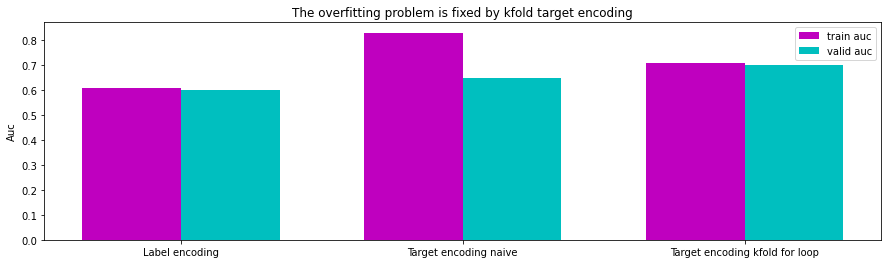

In [15]:
labels = ['Label encoding', 'Target encoding naive', 'Target encoding kfold for loop']
train_auc = [0.61, 0.83, 0.71]
valid_auc = [0.60, 0.65, 0.7]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
fig.set_figwidth(15)
rects1 = ax.bar(x - width/2, train_auc, width, label='train auc', color='m')
rects2 = ax.bar(x + width/2, valid_auc, width, label='valid auc', color='c')

ax.set_ylabel('Auc')
ax.set_title('The overfitting problem is fixed by kfold target encoding')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

<a id="opt"></a>
### An optimized implementation
We can make further improvements:
- calculate the encoding in one shot instead of the for loop.
- encode one column or many columns jointly
- smooth the encoding so that it is not skewed by infrequent values.
- support both single and multi gpus

In [16]:
class TargetEncoder:
    
    def __init__(self, folds, smooth, seed=42, mode='gpu'):
        self.folds = folds
        self.seed = seed
        self.smooth = smooth
        if mode=='gpu':
            self.np = cp
            self.df = gd
        else:
            self.np = np
            self.df = pd
        self.mode = mode
        
    def fit_transform(self, train, x_col, y_col, y_mean=None, out_col = None, out_dtype=None):
        
        self.y_col = y_col
        self.np.random.seed(self.seed)
        
        if 'fold' not in train.columns:
            fsize = len(train)//self.folds
            if isinstance(train,dask_cudf.core.DataFrame):
                #train['fold'] = train.map_partitions(lambda cudf_df: cudf_df.index%self.folds)
                train['fold'] = 1
                train['fold'] = train['fold'].cumsum()
                train['fold'] = train['fold']//fsize
                train['fold'] = train['fold']%self.folds
            else:
                #train['fold'] = self.np.random.randint(0,self.folds,len(train))
                train['fold'] = (train.index.values//fsize)%self.folds
        
        if out_col is None:
            tag = x_col if isinstance(x_col,str) else '_'.join(x_col)
            out_col = f'TE_{tag}_{self.y_col}'
        
        if y_mean is None:
            y_mean = train[y_col].mean()#.compute().astype('float32')
        self.mean = y_mean
        
        cols = ['fold',x_col] if isinstance(x_col,str) else ['fold']+x_col
        
        agg_each_fold = train.groupby(cols).agg({y_col:['count','sum']}).reset_index()
        agg_each_fold.columns = cols + ['count_y','sum_y']
        
        agg_all = agg_each_fold.groupby(x_col).agg({'count_y':'sum','sum_y':'sum'}).reset_index()
        cols = [x_col] if isinstance(x_col,str) else x_col
        agg_all.columns = cols + ['count_y_all','sum_y_all']
        
        agg_each_fold = agg_each_fold.merge(agg_all,on=x_col,how='left')
        agg_each_fold['count_y_all'] = agg_each_fold['count_y_all'] - agg_each_fold['count_y']
        agg_each_fold['sum_y_all'] = agg_each_fold['sum_y_all'] - agg_each_fold['sum_y']
        agg_each_fold[out_col] = (agg_each_fold['sum_y_all']+self.smooth*self.mean)/(agg_each_fold['count_y_all']+self.smooth)
        agg_each_fold = agg_each_fold.drop(['count_y_all','count_y','sum_y_all','sum_y'],axis=1)
        
        agg_all[out_col] = (agg_all['sum_y_all']+self.smooth*self.mean)/(agg_all['count_y_all']+self.smooth)
        agg_all = agg_all.drop(['count_y_all','sum_y_all'],axis=1)
        self.agg_all = agg_all
        
        train.columns
        cols = ['fold',x_col] if isinstance(x_col,str) else ['fold']+x_col
        train = train.merge(agg_each_fold,on=cols,how='left')
        del agg_each_fold
        #self.agg_each_fold = agg_each_fold
        if self.mode=='gpu':
            if isinstance(train,dask_cudf.core.DataFrame):
                train[out_col] = train.map_partitions(lambda cudf_df: cudf_df[out_col].nans_to_nulls())
            else:
                train[out_col] = train[out_col].nans_to_nulls()
        train[out_col] = train[out_col].fillna(self.mean)
        
        if out_dtype is not None:
            train[out_col] = train[out_col].astype(out_dtype)
        return train
    
    def transform(self, test, x_col, out_col = None, out_dtype=None):
        if out_col is None:
            tag = x_col if isinstance(x_col,str) else '_'.join(x_col)
            out_col = f'TE_{tag}_{self.y_col}'
        test = test.merge(self.agg_all,on=x_col,how='left')
        test[out_col] = test[out_col].fillna(self.mean)
        if out_dtype is not None:
            test[out_col] = test[out_col].astype(out_dtype)
        return test

In [17]:
# drop the previous TE columns
train = train.drop(te_cols, axis=1)
valid = valid.drop(te_cols, axis=1)

In [18]:
%%time

for col in cat_cols[:3]:
    out_col = f'{col}_TE'
    encoder = TargetEncoder(folds=FOLDS,smooth=20)
    train = encoder.fit_transform(train, col, 'label', out_col=out_col, out_dtype='float32')
    valid = encoder.transform(valid, col, out_col=out_col, out_dtype='float32')
    del encoder
train.head()

CPU times: user 117 ms, sys: 72.9 ms, total: 190 ms
Wall time: 189 ms


,label,cat_0,cat_1,cat_2,fold,row_id,cat_0_TE,cat_1_TE,cat_2_TE
0,0,370828,11313,7423,1,6912,0.008883,0.030515,0.038656
1,0,426089,10319,86,5,6913,0.006774,0.031737,0.026047
2,0,410417,13206,11827,8,6914,0.022669,0.019108,0.008202
3,0,189955,15451,6024,9,6915,0.018428,0.012774,0.022168
4,0,416995,15354,12390,9,6916,0.023713,0.111387,0.025572


Note that the optimized implementation is about 6x faster than the previous `for loop` based implementation.

In [19]:
te_cols = [col for col in train.columns if col.endswith('TE')]
print(te_cols)

NROUND = 100
VERBOSE_EVAL = 10
ESR = 10

start = time.time(); print('Creating DMatrix...')
dtrain = xgb.DMatrix(data=train[te_cols],label=train['label'])
dvalid = xgb.DMatrix(data=valid[te_cols],label=valid['label'])
print('Took %.1f seconds'%(time.time()-start))

start = time.time(); print('Training...')
model = xgb.train(xgb_parms, 
                       dtrain=dtrain,
                       evals=[(dtrain,'train'),(dvalid,'valid')],
                       num_boost_round=NROUND,
                       early_stopping_rounds=ESR,
                       verbose_eval=VERBOSE_EVAL) 

['cat_0_TE', 'cat_1_TE', 'cat_2_TE']
Creating DMatrix...
Took 0.0 seconds
Training...
[0]	train-auc:0.61010	valid-auc:0.59717
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[10]	train-auc:0.70187	valid-auc:0.69400
[20]	train-auc:0.69923	valid-auc:0.69010
[30]	train-auc:0.70503	valid-auc:0.69613
[40]	train-auc:0.70743	valid-auc:0.69945
[50]	train-auc:0.71170	valid-auc:0.70343
[60]	train-auc:0.71244	valid-auc:0.70412
[70]	train-auc:0.71339	valid-auc:0.70474
[80]	train-auc:0.71402	valid-auc:0.70530
[90]	train-auc:0.71439	valid-auc:0.70547
[99]	train-auc:0.71460	valid-auc:0.70560


The optimized version is slightly more accurate and it could be up to 10x faster than the `kfold for loop` implementation.

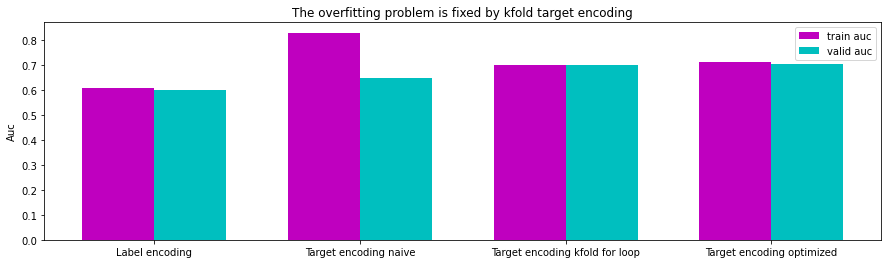

In [20]:
labels = ['Label encoding', 'Target encoding naive', 'Target encoding kfold for loop', 'Target encoding optimized']
train_auc = [0.61, 0.83, 0.7, 0.712]
valid_auc = [0.60, 0.65, 0.7, 0.704]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
fig.set_figwidth(15)
rects1 = ax.bar(x - width/2, train_auc, width, label='train auc', color='m')
rects2 = ax.bar(x + width/2, valid_auc, width, label='valid auc', color='c')

ax.set_ylabel('Auc')
ax.set_title('The overfitting problem is fixed by kfold target encoding')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

<a id="multi"></a>
### Multi-column joint encoding
Instead of encoding one column at a time, we can also encoding multiple columns jointly into one new feature.

In [21]:
%%time
for cols in [['cat_0', 'cat_1'],
             ['cat_0', 'cat_2'],
             ['cat_1', 'cat_2'],
             ['cat_0', 'cat_1', 'cat_2']
            ]:
    out_col = '_'.join(cols)+'_TE'
    encoder = TargetEncoder(folds=FOLDS,smooth=20)
    train = encoder.fit_transform(train, cols, 'label', out_col=out_col, out_dtype='float32')
    valid = encoder.transform(valid, cols, out_col=out_col, out_dtype='float32')
    del encoder

CPU times: user 241 ms, sys: 165 ms, total: 406 ms
Wall time: 405 ms


In [22]:
te_cols = [col for col in train.columns if col.endswith('TE')]
print(te_cols)

NROUND = 100
VERBOSE_EVAL = 10
ESR = 10

start = time.time(); print('Creating DMatrix...')
dtrain = xgb.DMatrix(data=train[te_cols],label=train['label'])
dvalid = xgb.DMatrix(data=valid[te_cols],label=valid['label'])
print('Took %.1f seconds'%(time.time()-start))

start = time.time(); print('Training...')
model = xgb.train(xgb_parms, 
                       dtrain=dtrain,
                       evals=[(dtrain,'train'),(dvalid,'valid')],
                       num_boost_round=NROUND,
                       early_stopping_rounds=ESR,
                       verbose_eval=VERBOSE_EVAL) 

['cat_0_TE', 'cat_1_TE', 'cat_2_TE', 'cat_0_cat_1_TE', 'cat_0_cat_2_TE', 'cat_1_cat_2_TE', 'cat_0_cat_1_cat_2_TE']
Creating DMatrix...
Took 0.0 seconds
Training...
[0]	train-auc:0.67973	valid-auc:0.67341
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[10]	train-auc:0.70705	valid-auc:0.69596
Stopping. Best iteration:
[5]	train-auc:0.71156	valid-auc:0.70120



Although the validation AUC doesn't improve for this dataset, the functionality of multi-column joint encoding is necessary and might improve the prediction for other datasets.

## 3. Conclusion

In this notebook, we explains the key design choices of target encoding. The takeaways are:
- The ground truth column `target` is used as input for encoding.
- The training data and test data are transformed differently.
- Multi-column joint transformation is supported by target encoding.